In [ ]:
%cd '/content/drive/My Drive/DGM'
!ls -la

/content/drive/My Drive/DGM
total 539249
-rw------- 1 root root    107208 Oct 24 12:39 Board.h
-rw------- 1 root root       150 Nov 15 20:47 compile.sh
-rw------- 1 root root      1048 Nov 19 20:36 config.py
-rw------- 1 root root      1540 Nov 19 18:21 dataloader.py
-rw------- 1 root root   8841872 Nov 19 19:56 DGV0.h5
-rw------- 1 root root       169 Nov 19 19:56 DGV0_history
-rw------- 1 root root     15320 Oct 24 12:39 Game.h
-rw------- 1 root root 542497580 Nov 15 22:41 games.data
-rw------- 1 root root     12273 Oct 24 16:29 golois.cpp
-rw------- 1 root root    236328 Nov 19 13:13 golois.cpython-37m-x86_64-linux-gnu.so
-rw------- 1 root root    236328 Nov 15 23:00 golois.cpython-38-x86_64-linux-gnu.so
-rw------- 1 root root      2575 Nov 19 14:12 golois.py
drwx------ 2 root root      4096 Nov 19 20:37 model_imgs
-rw------- 1 root root      4707 Nov 19 20:36 model.py
drwx------ 2 root root      4096 Nov 19 20:36 __pycache__
-rw------- 1 root root      6420 Oct 24 12:39 Rzone.h
-rw

In [ ]:
!python golois.py

getValidation
r.shape = (10000, 19, 19, 31)
nbExamples = 10000
tcmalloc: large alloc 2400002048 bytes == 0x558c5e05a000 @  0x7f1508c5b887 0x7f147746d0d9 0x7f147747285f 0x7f147748706f 0x558c073b04b0 0x558c073b0240 0x558c074240f3 0x558c0741e9ee 0x558c0741e6f3 0x558c074e84c2 0x558c074e883d 0x558c074e86e6 0x558c074c0163 0x558c074bfe0c 0x7f1507a43bf7 0x558c074bfcea
nbPositionsSGF = 29425326
nbPositionsSGF = 29425326
loading validation.data
2021-11-19 18:33:27.178634: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board (InputLayer)             [(None, 19, 19, 31)  0           []                               
                               

In [7]:
!python train.py

2021-11-19 20:42:04.827416: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board (InputLayer)             [(None, 19, 19, 31)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 19, 19, 64)   2048        ['board[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 19, 19, 64)   17920       ['board[0][0]']                  
                               

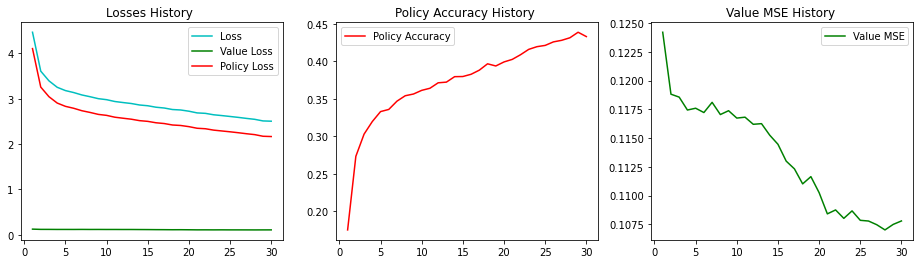

In [25]:
import pickle 
import matplotlib.pyplot as plt


with open('DGV0_history', 'rb') as f_hist:
    history = pickle.load(f_hist)



def get_metric(d,key):
    return [v[key][0] for _,v in d.items()]

def plots(epochs , history):
    
    # metrics = ['loss','policy_loss','value_loss','policy_categorical_accuracy','value_mse']
    
    # Losses
    loss = get_metric(history,'loss')
    policy_loss = get_metric(history,'policy_loss')
    value_loss = get_metric(history,'value_mse')

    # Accuracy 
    policy_acc = get_metric(history,'policy_categorical_accuracy')

    # MSE 
    value_mse = get_metric(history,'value_mse')
    


    fig,(ax_loss,ax_acc,ax_mse) = plt.subplots(1,3)
    fig.set_size_inches((16,4))

    # Losses 
    ax_loss.plot(epochs, loss ,'c',label = 'Loss')
    ax_loss.plot(epochs, value_loss, 'g' , label = 'Value Loss')
    ax_loss.plot(epochs, policy_loss ,'r',label = 'Policy Loss')
    ax_loss.set_title('Losses History ')
    ax_loss.legend()

    # Accuracy
    ax_acc.plot(epochs, policy_acc , 'r',label = 'Policy Accuracy')
    ax_acc.set_title('Policy Accuracy History ')
    ax_acc.legend()

    # MSE
    ax_mse.plot(epochs, value_mse , 'g',label = 'Value MSE')
    ax_mse.set_title('Value MSE History ')
    ax_mse.legend()

    fig.show()





epochs = list(history.keys())
plots(epochs,history)

In [ ]:
!python train.py

2021-11-19 16:09:29.438138: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board (InputLayer)             [(None, 19, 19, 31)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 19, 19, 64)   17920       ['board[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 19, 19, 64)   49664       ['board[0

In [ ]:
!python train.py

2021-11-19 16:25:13.287454: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board (InputLayer)             [(None, 19, 19, 31)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 19, 19, 64)   17920       ['board[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 19, 19, 64)   49664       ['board[0